`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   




# Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии. 

В практических примерах ниже показано:   

* как снижать размерность пространства признаков методами частных наименьшах квадратов (PLS)  
* как строить логистическую регрессию с регуляризацией параметров (лассо) 

Точность всех моделей оценивается методом перекрёстной проверки по 10 блокам.  

*Модели*: множественная линейная регрессия 


# Указания к выполнению


## Загружаем пакеты

In [1]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  стандартизация показателей
from sklearn.preprocessing import StandardScaler
#  метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
#  логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#  перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
#  расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# константы
#  ядро для генератора случайных чисел
my_seed = 6
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [3]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
#  из репозитория к книге С.Рашки Python и машинное обучение,
#  слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
                        C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)    
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, 
                                C=10.**c, solver='liblinear', 
                                multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
                 label=col_names[column],
                 color=color)

    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', 
                linestyle='--', linewidth=1)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', 
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

## Загружаем данные

Набор данных `winequality-white_for_lab` в формате .csv доступен для загрузки по адресу: <https://raw.githubusercontent.com/ania607/ML/main/data/winequality-white_for_lab.csv>. 
Загружаем данные во фрейм
* `fixed_acidity` – постоянная кислотность;  
* `volatile_acidity` – переменная кислотность;  
* `citric_acid` – содержание лимонной кислоты;  
* `residual_sugar` – остаточный сахар;  
* `chlorides` – содержание хлоридов;  
* `free_sulfur_dioxide` – содержание диоксида серы в свободном виде;  
* `total_sulfur_dioxide` – общее содержание диоксида серы;  
* `density` – плотность;  
* `pH` – кислотность; 
* `sulphates` – содержание сульфатов;  
* `alcohol` – содержание алкоголя;  
* `quality` – балльная оценка качества вина, от 0 до 10;  
* `Y` – целевая переменная: 1 = высокое качество (`quality` > 5), 0 = низкое (`quality` <= 5).
Загружаем данные во фрейм и выясняем их размерность.  

In [6]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/winequality-white_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (4898, 13)


Отложим 15% наблюдений для прогноза.  

In [7]:
# наблюдения для моделирования
DF = DF_raw.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_raw.drop(DF.index)

In [8]:
# первые 5 строк фрейма у первых 7 столбцов
DF.iloc[:, :7].head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide
3765,6.9,0.40,0.17,12.9,0.033,59.0,186.0
154,8.2,0.23,0.40,7.5,0.049,12.0,76.0
1383,7.1,0.36,0.56,1.3,0.046,25.0,102.0
568,6.1,0.26,0.51,2.2,0.050,61.0,154.0
1338,6.7,0.18,0.30,6.4,0.048,40.0,251.0


In [9]:
# первые 5 строк фрейма у столбцов 8-11
DF.iloc[:, 7:11].head(5)

,density,pH,sulphates,alcohol
3765,0.99754,3.08,0.49,9.4
154,0.99660,3.06,0.84,9.7
1383,0.99230,3.24,0.33,10.5
568,0.99290,3.08,0.60,9.8
1338,0.99560,3.29,0.52,10.0


In [10]:
# первые 5 строк фрейма у столбцов 12-13
DF.iloc[:, 11:].head(5)

,quality,Y
3765,5,0
154,6,1
1383,6,1
568,6,1
1338,5,0


In [11]:
# типы столбцов фрейма
DF.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Y                         int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [12]:
# считаем пропуски в каждом столбце
DF.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Y                       0
dtype: int64

In [13]:
# оставляем в наборе данных только то, что нужно 
DF_all = DF_raw[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 
                 'pH', 'sulphates', 'alcohol', 'Y']]
DF_all.columns


Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'pH', 'sulphates', 'alcohol', 'Y'],
      dtype='object')

In [14]:
DF_all.dtypes

fixed_acidity          float64
volatile_acidity       float64
citric_acid            float64
residual_sugar         float64
chlorides              float64
free_sulfur_dioxide    float64
pH                     float64
sulphates              float64
alcohol                float64
Y                        int64
dtype: object

In [15]:
# удаляем фрейм-исходник
del DF_raw

In [16]:
# наблюдения для моделирования
DF = DF_all.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)

In [21]:
# первые 5 строк фрейма у первых 7 столбцов
DF.iloc[:, :7].head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,pH
3765,6.9,0.40,0.17,12.9,0.033,59.0,3.08
154,8.2,0.23,0.40,7.5,0.049,12.0,3.06
1383,7.1,0.36,0.56,1.3,0.046,25.0,3.24
568,6.1,0.26,0.51,2.2,0.050,61.0,3.08
1338,6.7,0.18,0.30,6.4,0.048,40.0,3.29


In [20]:
# первые 5 строк фрейма у столбцов 8-11
DF.iloc[:, 7:11].head(5)

,sulphates,alcohol,Y
3765,0.49,9.4,0
154,0.84,9.7,1
1383,0.33,10.5,1
568,0.60,9.8,1
1338,0.52,10.0,0


In [23]:
# считаем пропуски в каждом столбце
DF.isna().sum()

fixed_acidity          0
volatile_acidity       0
citric_acid            0
residual_sugar         0
chlorides              0
free_sulfur_dioxide    0
pH                     0
sulphates              0
alcohol                0
Y                      0
dtype: int64

пропусков не обнаружено.

In [24]:
# метки классов
DF.Y.unique()

array([0, 1], dtype=int64)

In [25]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

1    0.664
0    0.336
Name: Y, dtype: float64

Все объясняющие переменные набора данных непрерывные. Рассчитаем для них описательные статистики.  

In [26]:
# описательные статистики
DF.iloc[:, :6].describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide
count,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000
mean,6.849135,0.278086,0.333541,6.366731,0.045917,35.201417
std,0.844912,0.100482,0.118623,5.088573,0.022027,17.003168
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000
50%,6.800000,0.260000,0.320000,5.100000,0.043000,34.000000
75%,7.300000,0.320000,0.380000,9.800000,0.050000,45.000000
max,14.200000,1.100000,1.230000,65.800000,0.346000,289.000000


In [27]:
# описательные статистики
DF.iloc[:, 6:9].describe()

,pH,sulphates,alcohol
count,4163.000000,4163.000000,4163.000000
mean,3.189784,0.489926,10.522423
std,0.151397,0.113545,1.233513
min,2.720000,0.220000,8.000000
25%,3.090000,0.410000,9.500000
50%,3.180000,0.480000,10.400000
75%,3.280000,0.550000,11.400000
max,3.820000,1.080000,14.200000


Выводы по описательным статистикам: значения объясняющих переменных положительные, масштабы измерения отличаются. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.   

## Визуализация разброса переменных внутри классов  

Поскольку в наборе данных 9 объясняющих переменных, и все они непрерывные, анализ матричного графика разброса будет затруднительным. Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.  

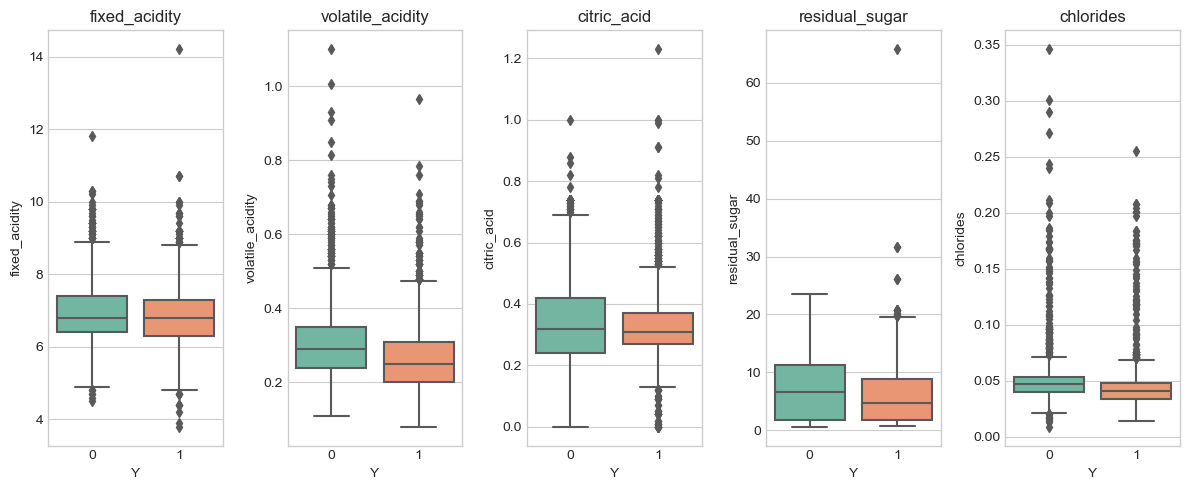

In [29]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

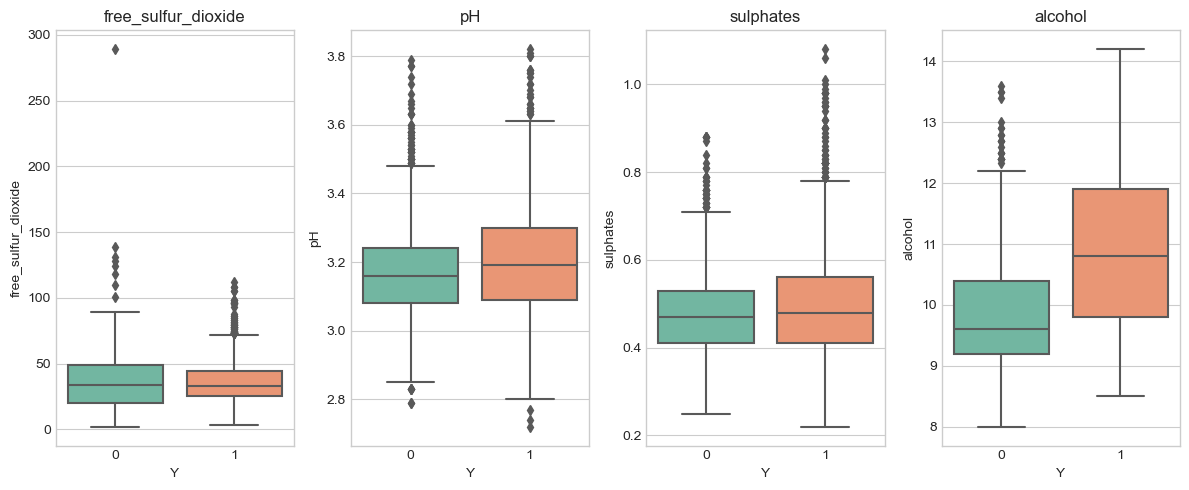

In [30]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
axs = [ax1, ax2, ax3, ax4]

cols_loop = list(DF.columns[5:9].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

На графиках отличие в медианах и разбросе между классами прослеживается практически по всем объясняющим переменным. Меньше всего различаются коробчатые диаграммы по переменной `fixed_acidity`. Это говорит о том, классы по зависимой переменной `Y` неплохо разделяются по всем объясняющим переменным.  

## Корреляционный анализ   

Теперь посмотрим на взаимодействие объясняющих переменных.  

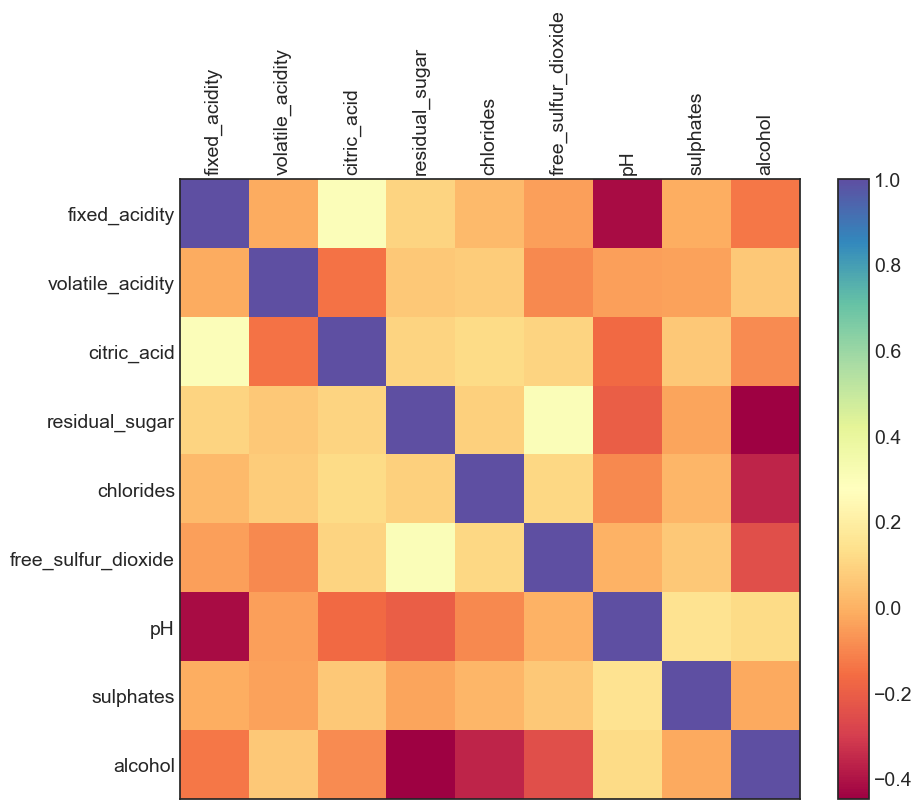

In [31]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='Spectral')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими переменными обнаруживаются как прямые, так и обратные линейные взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим минимальный / максимальный из них.     

In [32]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
#  и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
#  корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция ** 2))
df['P_значение'] = 2 * (1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
#  выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
25,residual_sugar,alcohol,-0.447697,0.0
5,fixed_acidity,pH,-0.418559,0.0
29,chlorides,alcohol,-0.360616,0.0
32,free_sulfur_dioxide,alcohol,-0.247313,0.0
23,residual_sugar,pH,-0.203264,0.0
18,citric_acid,pH,-0.169560,0.0
8,volatile_acidity,citric_acid,-0.145669,0.0
7,fixed_acidity,alcohol,-0.132652,0.0
27,chlorides,pH,-0.095248,0.0
11,volatile_acidity,free_sulfur_dioxide,-0.094752,0.0


# Методы снижения резмерности  

Посмотрим, как работает метод снижения размерности:  

   
* частный метод наименьших квадратов (PLS)  

Этот метод требует предварительной стандартизации переменных.  

In [33]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :10].values)

# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
          np.round(np.mean(X_train_std[:, i_col]), 2),
         '   Станд. отклонение = ', 
          np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = -0.0   Станд. отклонение = 1.0
Столбец 1: среднее = 0.0   Станд. отклонение = 1.0
Столбец 2: среднее = 0.0   Станд. отклонение = 1.0
Столбец 3: среднее = 0.0   Станд. отклонение = 1.0
Столбец 4: среднее = -0.0   Станд. отклонение = 1.0
Столбец 5: среднее = -0.0   Станд. отклонение = 1.0
Столбец 6: среднее = 0.0   Станд. отклонение = 1.0
Столбец 7: среднее = 0.0   Станд. отклонение = 1.0
Столбец 8: среднее = 0.0   Станд. отклонение = 1.0
Столбец 9: среднее = -0.0   Станд. отклонение = 1.0


## Метод частных наименьших квадратов  

Сначала посмотрим, как работает метод на всех наблюдениях обучающего набора.  

In [34]:
# функция для оценки модели, берём все компоненты, по числу столбцов X
pls = PLSRegression(n_components=10)
# значения зависимой переменной превращаем в фиктивные по классам
Y_train = pd.get_dummies(DF.Y.astype(str))
# оцениваем
pls.fit(X_train_std, Y_train)

# считаем долю объяснённой дисперсии
frac_var_expl = np.var(pls.x_scores_, axis=0) / np.sum(np.var(X_train_std, axis=0))
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
     np.around(frac_var_expl, 3),
     '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.151 0.126 0.094 0.058 0.086 0.085 0.086 0.07  0.073 0.087] 
Общая сумма долей: 0.916


Из-за того, что при вычислении компонент метдом PLS мы учитываем корреляцию с $Y$, компоненты, во-первых, не ортогональны, а во-вторых сумма объяснённых долей дисперсии уже не равняется 1.  

In [35]:
# сокращаем пространство компонент до 2
pls = PLSRegression(n_components=2)
# перестраиваем модель
pls.fit(X_train_std, Y_train)
# пересчитываем X
X_train_pls = pls.transform(X_train_std)
# предсказываем принадлежности классов для обучающего набора
Y_train_pred = pls.predict(X_train_std)
pd.DataFrame(Y_train_pred)

,0,1
0,0.985989,0.014011
1,0.027279,0.972721
2,0.118612,0.881388
3,0.002392,0.997608
4,0.911372,0.088628
...,...,...
4158,0.984676,0.015324
4159,-0.093506,1.093506
4160,0.029462,0.970538
4161,0.929529,0.070471


In [36]:
# вычисляем классы
Y_train_hat = list()
for y_i in Y_train_pred : 
    Y_train_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
# Y_train_hat
# сколько наблюдений попали в каждый класс по модели
Counter(Y_train_hat).items()

dict_items([(0, 1397), (1, 2766)])

Рисуем классы на графике в координатах 2 главных компонент по PLS.  

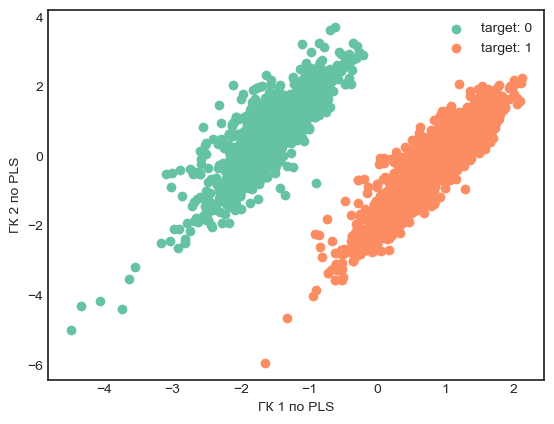

In [38]:
# график классов в пространстве ГК
plt.scatter(X_train_pls[DF['Y'] == 0][:, 0], 
            X_train_pls[DF['Y'] == 0][:, 1], label='target: 0')
plt.scatter(X_train_pls[DF['Y'] == 1][:, 0], 
            X_train_pls[DF['Y'] == 1][:, 1], label='target: 1')
plt.xlabel('ГК 1 по PLS')
plt.ylabel('ГК 2 по PLS')
plt.legend()
plt.show()

Видно, что в координатах двух компонент, рассчитанных методом частных наименьших квадратов, классы также оказываются хорошо разделимы.  
Теперь оценим точность модели с перекрёстной проверкой.  

In [39]:
# функция разбиения на блоки для перекрёстной проверки
#  для чистоты эксперимента возьмём другое ядро генератора случайных чисел
kf_10 = KFold(n_splits=10, random_state=my_seed+1, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
#  функция cross_val_score не сработает, т.к. у нас мультиклассовая
#  классификация, поэтому делаем вручную
# значения Y как метки классов
Y_train = DF.Y.values
# значения Y как фиктивные переменные
Y_train_dummy = pd.get_dummies(Y_train.astype(str))
# модель внутри блока
pls_cv = PLSRegression(n_components=2)
# для записи Acc по блокам
acc_blocks = list()
# цикл по блокам
for train_index, test_index in kf_10.split(X_train_std, DF.Y.values) : 
    # данные для модели внутри блока
    X_i_train = X_train_std[train_index]
    Y_i_train = Y_train_dummy.iloc[train_index, :]

    # данные для прогноза вне блока
    X_i_test = X_train_std[test_index]
    Y_i_test = Y_train[test_index]

    # оцениваем модель на блоке
    pls_cv.fit(X_i_train, Y_i_train)
    # делаем прогноз y вне блока
    Y_pred = pls.predict(X_i_test)
    Y_hat = list()
    for y_i in Y_pred : 
        Y_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
    # считаем точность
    acc = accuracy_score(Y_i_test, Y_hat)
    acc_blocks.append(acc)
score = list()
score_models = list()
score.append(np.around(np.mean(acc_blocks), 3))
score_models.append('logit_PLS')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 2), sep='')


Модель logit_PLS, перекрёстная проверка по 10 блокам
Acc = 1.0


# Методы сжатия

Функция `LogisticRegression()` умеет работать с мультиклассовой классификацией, используя при оценке параметров подход **один класс против остальных**. Построим ридж на наших данных.  

## Лассо-регрессия

Технически реализация лассо-регрессии отличается от ридж единственным аргументом `penalty='l1'` в функции `LogisticRegression`.    

In [40]:
# функция для построения модели
logit_lasso = LogisticRegression(penalty='l1', solver='liblinear')
# оцениваем параметры
logit_lasso.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_lasso.intercept_, 3),
     '\nКоэффициенты моделей для классов:\n', np.around(logit_lasso.coef_, 3))

Константы моделей для классов:
 [2.161] 
Коэффициенты моделей для классов:
 [[0.    0.    0.    0.    0.    0.    0.    0.    0.    7.899]]


Отметим, что в векторе коэффициентов появились нулевые значения: метод лассо позволяет обнулять коэффициенты, тем самым отбрасывая слабые объясняющие переменные.  

In [41]:
# поиск оптимального значения C:
#  подбираем C по наибольшей точности с перекрёстной проверкой
lasso_cv = LogisticRegressionCV(cv=10, random_state=my_seed+3,
                               penalty='l1', solver='liblinear')
lasso_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
#  точность для каждого класса
lasso_cv.C_

array([0.00077426])

In [42]:
# сохраняем и выводим Acc для модели
score.append(np.around(lasso_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_lasso')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', score[0], sep='')

Модель logit_PLS, перекрёстная проверка по 10 блокам
Acc = 1.0


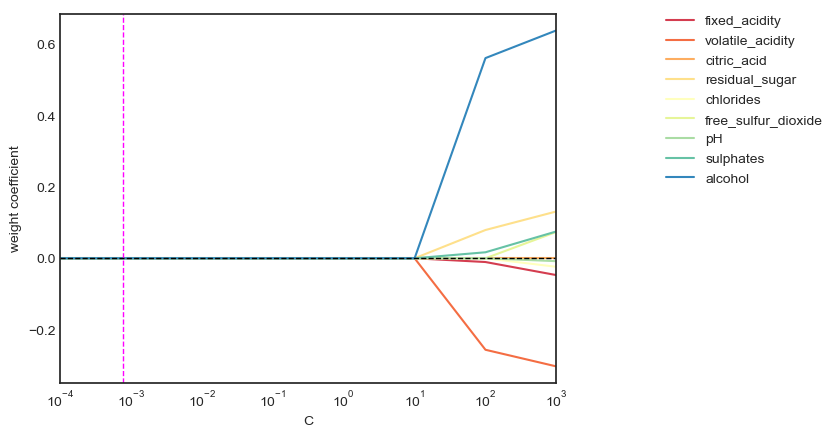

In [43]:
# график динамики коэффициентов в лассо-регрессии    
#  модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l1', lasso_cv.C_, DF.columns)

Итак, судя по графикам, для значения гиперпараметра, дающего самую точную модель, ни один коэффициент при объясняющих переменных не обнуляется. Это подтверждает наблюдение, сделанное нами ещё на этапе предварительного анализа: все объясняющие переменные неплохо разделяют классы.   


# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [44]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PLS,1.0
1,logit_lasso,1.0


Все модели показывают высокую точность по показателю $Acc$, при этом самой точной оказывается лассо-регрессия. Сделаем прогноз на отложенные наблюдения.   

In [45]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.iloc[:, :10].values)
Y_pred = DF_predict.Y
Y_hat = logit_lasso.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      1.00      1.00       492

    accuracy                           1.00       735
   macro avg       1.00      1.00      1.00       735
weighted avg       1.00      1.00      1.00       735



Итак, методом логистической регрессии со сжатием коэффициенты с L1-регуляризацией мы получили идеально точную модель классификации двух разновидностей качества (высокое и низкое).  

# Источники 

1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. Репозиторий с кодом к книге *Рашка С.* Python и машинное обучение / github.com. URL: <https://github.com/rasbt/python-machine-learning-book-3rd-edition>  
1. *Xueting Bai*, *Lingbo Wang*, *Hanning Li* Identification of red wine categories based on physicochemical properties / 2019 5th International Conference on Education Technology, Management and Humanities Science (ETMHS 2019). URL: <https://webofproceedings.org/proceedings_series/ESSP/ETMHS%202019/ETMHS19309.pdf>  

